<a href="https://colab.research.google.com/github/fabiohas/forecast_acidentes_transito/blob/main/acidentes_transito_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecast de acidentes de trânsito - análise exploratória de dados**

O conjunto de dados principal é formado pelos registros de acidentes de trânsito na cidade de Recife/PE durante os anos de 2015 e 2019. Foram usadas bases de trânsito disponibilizadas pela Autarquia de Trânsito e Transporte Urbano do Recife - CTTU no portal de dados abertos da prefeitura de Recife (https://www.emprel.gov.br/).

> Bloco com recuo



Cada registro contém uma variedade de informações que caracterizam o acidente. Não há um padrão definido entre os arquivos, cada ano contém diferentes colunas, apenas algumas constam em todos os arquivos.

Dentre as informações, podemos destacar (usando 2019 como exemplo):

| código        | descrição                                                                                            | tipo     |
| ------------- | ---------------------------------------------------------------------------------------------------- | -------- |
| tipo          | Tipo do Acidente se foi com ou sem vitimas                                                           | caracter |
| situacao      | Situação do atendimento                                                                              | caracter |
| data          | Data do atendimento                                                                                  | data     |
| hora          | Hora do atendimento                                                                                  | numérico |
| bairro        | Bairro do acidente                                                                                   | caracter |
| endereco      | Endereço do acidente                                                                                 | caracter |
| numero        | Número do acidente                                                                                   | numérico |
| complemento   | Complemento do acidente                                                                              | caracter |
| natureza      | Tipo de Ocorrencia                                                                                   | caracter |
| descricao     | Descrição do acidente                                                                                | caracter |
| auto          | Quantidade de automoveis no acidente                                                                 | numérico |
| moto          | Quantidade de motos no acidente                                                                      | numérico |
| ciclom        | Quantidade de ciclomotor no acidente                                                                 | numérico |
| ciclista      | Quantidade de bicicleta no acidente                                                                  | numérico |
| pedestre      | Quantidade de pedestres no acidente                                                                  | numérico |
| onibus        | Quantidade de onibus no acidente                                                                     | numérico |
| caminhao      | Quantidade de caminhão no acidente                                                                   | numérico |
| viatura       | Quantidade de viaturas no acidente                                                                   | numérico |
| outros        | Quantidade de outros veiculos no acidente                                                            | numérico |
| vitimas       | Quantidade de vitimas no acidente. A partir de 2017 essa coluna contém apenas as vítimas não fatais. | caracter |
| vitimasfatais | Quantidade de vitimas fatais no acidente                                                             | numérico |

Uma breve descrição dos níveis da variável `situacao`, obtida em http://dados.recife.pe.gov.br/, é descrita abaixo:

*   `situacao` (finalizada, cancelada, em andamento entre outras) 
    * Em Andamento: acidente não teve finalização, a equipe foi enviada ao local mas não deu retorno sobre a ocorrência.
    * Finalizada: houve retorno da equipe, podendo ser um número de boletim de ocorrência ou a informação de que foi feita fiscalização.
    * Cancelado: É quando a viatura não encontra a reclamação de acidente ou quando os envolvidos ligam dizendo que entraram em acordo.

Como estamos interessados em predizer a quantidade de acidentes, vamos sumarizar os dados fazendo, primeiramente, uma contagem de quantos registros de acidente temos por dia e nomear esta nova coluna como `num_acidentes` (número de acidentes por dia).

Podemos utilizar as variáveis existentes para construírmos novas variáveis que possivelmente podem ajudar a melhorar o poder preditivo do nosso modelo.





In [ ]:
#!pip install pyyaml==5.4.1

In [ ]:
#!pip install darts
#!pip install -U ridgeplot
#!pip install joypy
#!pip install dcor

In [ ]:
from darts import TimeSeries
from darts.utils.statistics import plot_acf, plot_pacf, plot_hist, check_seasonality, stationarity_test_adf, stationarity_test_kpss, stationarity_tests, extract_trend_and_seasonality

import statsmodels.api as sm

from joypy import joyplot
import matplotlib.pyplot as plt
from ridgeplot import ridgeplot
import seaborn as sns
import pandas as pd
import numpy as np
import dcor
import glob
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = r'/content/drive/MyDrive/my_notebooks/desafio_gavb/'
path_multas = path + 'external_data/'
path_acidentes = path + 'datasets/'

**Colunas em cada um dos arquivos anuais**

In [ ]:
arq_acidentes = glob.glob(os.path.join(path_acidentes , "*.csv"))

for filename in arq_acidentes:
    print("Características dos registros de", ''.join([n for n in filename if n.isdigit()]))
    print(pd.read_csv(filename, index_col=None, header=0).columns.tolist())

Características dos registros de 2018
['data', 'hora', 'natureza_acidente', 'situacao', 'bairro', 'endereco', 'numero', 'detalhe_endereco_acidente', 'complemento', 'endereco_cruzamento', 'numero_cruzamento', 'referencia_cruzamento', 'bairro_cruzamento', 'num_semaforo', 'sentido_via', 'tipo', 'descricao', 'auto', 'moto', 'ciclom', 'ciclista', 'pedestre', 'onibus', 'caminhao', 'viatura', 'outros', 'vitimas', 'vitimasfatais', 'acidente_verificado', 'tempo_clima', 'situacao_semaforo', 'sinalizacao', 'condicao_via', 'conservacao_via', 'ponto_controle', 'situacao_placa', 'velocidade_max_via', 'mao_direcao', 'divisao_via1', 'divisao_via2', 'divisao_via3', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44']
Características dos registros de 2016
['data', 'hora', 'natureza_acidente', 'situacao', 'bairro', 'endereco', 'numero', 'detalhe_endereco_acidente', 'complemento', 'endereco_cruzamento', 'numero_cruzamento', 'referencia_cruzamento', 'bairro_cruzamento', 'tipo', 'descricao', 'auto', 

**Fizemos o filtro de situação CANCELADA ou FINALIZADA por entender que se tratam de ocorrências com informações mais adequadas e que representam mais de 90% dos registros de cada ano**

In [ ]:
for filename in arq_acidentes:
  df_aux = pd.read_csv(filename, index_col=None, header=0)
  perc = df_aux.situacao.value_counts(normalize=True).to_frame('percentual')
  perc['percentual_acum'] = perc['percentual'].cumsum()
  print("Percentual acumulado de ocorrências por tipo de situação do ano de", ''.join([n for n in filename if n.isdigit()]))
  print(perc[['percentual_acum']])

Percentual acumulado de ocorrências por tipo de situação do ano de 2018
                        percentual_acum
FINALIZADA                     0.832296
CANCELADA                      0.988253
EQUIPE EM DESLOCAMENTO         0.993688
PENDENTE                       0.997633
DUPLICIDADE                    0.999386
EQUIPE NO LOCAL                0.999825
EM ABERTO                      1.000000
Percentual acumulado de ocorrências por tipo de situação do ano de 2016
                percentual_acum
FINALIZADA             0.756370
CANCELADA              0.974074
EM ATENDIMENTO         0.990322
PENDENTE               0.998579
EM ABERTO              0.999822
DUPLICIDADE            1.000000
Percentual acumulado de ocorrências por tipo de situação do ano de 2017
                        percentual_acum
FINALIZADA                     0.787367
CANCELADA                      0.977123
PENDENTE                       0.993683
EM ATENDIMENTO                 0.996756
EQUIPE EM DESLOCAMENTO         0.999488


## **Dados de acidentes de trânsito**

Além do filtro mencionado, fizemos a contagem de registros diários (*target*) e criamos duas variáveis, que serão exógenas no modelo:

*   `num_vitimas`: total de vítimas na data
*   `bairros_envolvidos`: quantidade única de bairros nos quais houveram ocorrências na data

Temos como hipótese que há uma relação positiva entre o número de acidentes e estas variáveis exógenas.

In [ ]:
del df_aux

lista_csv_ac = []

for filename in arq_acidentes:
    df_aux = pd.read_csv(filename, index_col=None, header=0)\
      .query("situacao=='CANCELADA' | situacao=='FINALIZADA'")
    df_aux.index = pd.to_datetime(df_aux['data'])
    df_aux = df_aux.drop_duplicates().groupby(pd.Grouper(level='data', freq='1D'))\
      .agg({'data':'count', 'vitimas':'sum', 'bairro':'nunique'})\
      .rename({'data':'num_acidentes', 'vitimas':'num_vitimas', 'bairro':'bairros_envolvidos'}, axis= 1)
    lista_csv_ac.append(df_aux)

df_acidentes = pd.concat(lista_csv_ac, axis=0).sort_index()
df_acidentes.index = df_acidentes.asfreq('d', method = 'bfill').index

In [ ]:
df_acidentes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1675 entries, 2015-06-01 to 2019-12-31
Freq: D
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_acidentes       1675 non-null   int64  
 1   num_vitimas         1675 non-null   float64
 2   bairros_envolvidos  1675 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 116.9 KB


## **Dados de infrações de trânsito**

Também trabalharemos com um conjunto de dados com registros de infrações de trânsito pela CTTU na cidade de Recife/PE durante o mesmo período, para enriquecer a análise, retirados de http://dados.recife.pe.gov.br/. Levantamos a hipótese de que esses dados podem ser relevantes para a análise, de forma que possuam forte correlação com a variável de interesse.

Nestes arquivos estamos interessados apenas na contagem de registros diários de multas.

In [ ]:
del df_aux

arq_multas = glob.glob(os.path.join(path_multas , "*.csv"))

lista_csv_multas = []

for filename in arq_multas:
    df_aux = pd.read_csv(filename, index_col=None, header=0, sep = ';')
    df_aux.index = pd.to_datetime(df_aux['datainfracao'])
    df_aux = df_aux.drop_duplicates()\
      .groupby(pd.Grouper(level='datainfracao', freq='1D'))\
      .size().to_frame('num_infracoes')
    lista_csv_multas.append(df_aux)

df_multas = pd.concat(lista_csv_multas, axis=0).sort_index()
df_multas.index = df_multas.asfreq('d', method = 'bfill').index

In [ ]:
df_multas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 to 2019-12-31
Freq: D
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   num_infracoes  1826 non-null   int64
dtypes: int64(1)
memory usage: 28.5 KB


## **Conjunto de dados final**

Temos um conjunto final com dados por dia, totalizando 1675 pontos, contendo as seguintes variáveis
* *Target* - num_acidentes
* Exógenas - num_vitimas, bairros_envolvidos, num_infracoes, dia_semana, mes, ano

In [ ]:
df = df_acidentes.merge(df_multas, left_index=True, right_index=True, how = 'left')

df['dia_semana'] = df.index.strftime('%A').to_list()
df['mes'] = df.index.month
df['ano'] = df.index.year

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1675 entries, 2015-06-01 to 2019-12-31
Freq: D
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_acidentes       1675 non-null   int64  
 1   num_vitimas         1675 non-null   float64
 2   bairros_envolvidos  1675 non-null   int64  
 3   num_infracoes       1675 non-null   int64  
 4   dia_semana          1675 non-null   object 
 5   mes                 1675 non-null   int64  
 6   ano                 1675 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 169.2+ KB


# Analisando o comportamento da variável de interesse

Estamos interessados em prever a quantidade de ocorrências de acidentes de transito.

Por ser uma série temporal é importante verificarmos se o comportamento da variável se altera com o passar do tempo.

Para isso vamos fazer uma análise gráfica do comportamento probabilístico dessa variável.

## Comportamento anual

<Figure size 1080x432 with 0 Axes>

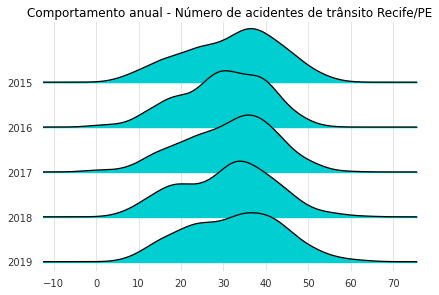

In [ ]:
plt.figure(figsize=(15,6))
joyplot(data=df,column='num_acidentes', by="ano", overlap=0.5,  color='darkturquoise')
plt.title('Comportamento anual - Número de acidentes de trânsito Recife/PE')
plt.grid()


## Comportamento mensal

<Figure size 1080x432 with 0 Axes>

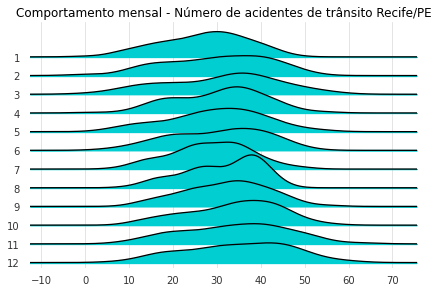

In [ ]:
plt.figure(figsize=(15,6))
joyplot(data=df,column='num_acidentes', by="mes", overlap=0.5,  color='darkturquoise')
plt.title('Comportamento mensal - Número de acidentes de trânsito Recife/PE')
plt.grid()

A variável se comporta de maneira estável com o passar do tempo. Apresentando pouco ou quase nada de drift.

Essa é uma característica importante para o objetivo da solução preditiva que iremos desenvolver.

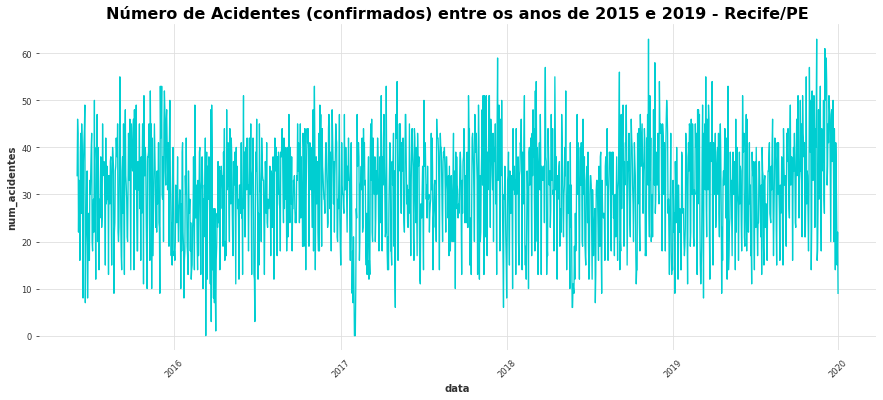

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df['num_acidentes'], color='darkturquoise')
plt.xticks(rotation=45)
plt.title('Número de Acidentes (confirmados) entre os anos de 2015 e 2019 - Recife/PE', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
plt.show()

## Ajustes

Percebe-se que existem dias com zero registro de acidentes. Provavelmente isso se deve ao filtro definido para as ocorrências.

In [ ]:
df.describe()

,num_acidentes,num_vitimas,bairros_envolvidos,num_infracoes,mes,ano
count,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000,1675.000000
mean,31.288358,5.841194,20.179701,1928.127761,6.840000,2017.179701
std,10.736602,3.262853,5.585702,626.683582,3.402606,1.337116
min,0.000000,0.000000,0.000000,270.000000,1.000000,2015.000000
25%,24.000000,4.000000,17.000000,1508.500000,4.000000,2016.000000
50%,32.000000,5.000000,21.000000,1863.000000,7.000000,2017.000000
75%,39.000000,8.000000,24.000000,2271.500000,10.000000,2018.000000
max,63.000000,28.000000,36.000000,7047.000000,12.000000,2019.000000


In [ ]:
df.query("num_acidentes==0 | bairros_envolvidos==0")

,num_acidentes,num_vitimas,bairros_envolvidos,num_infracoes,dia_semana,mes,ano
data,,,,,,,
2016-03-10,0,0.0,0,845,Thursday,3,2016
2017-01-31,0,0.0,0,784,Tuesday,1,2017
2017-02-01,0,0.0,0,688,Wednesday,2,2017
2017-02-02,0,0.0,0,768,Thursday,2,2017


Como são poucos pontos podemos imputar de maneira pontual cada um desses registros zerados utilizando o método *backward*, substituindo os zeros pelo próximo valor não nulo. Também faremos a mesma imputação na variável bairros_envolvidos.

In [ ]:
df[['num_acidentes', 'bairros_envolvidos']] = df[['num_acidentes', 'bairros_envolvidos']].replace(to_replace=0, method='bfill')

# Análise Descritiva

Sabe-se que em períodos de festividades como carnaval, natal e reveillon as estatísticas de acidentes no transito aumentam devido ao grande deslocamento de pessoas nestas datas.

Sumarizando a quantidade de acidentes de forma mensal, os meses de **Fevereiro, Março, Setembro, Outubro, Novembro e Dezembro**  apresentam números mais expressivos de acidentes se comparados com os demais(**gráfico 1**).

Percebe-se também uma tendência positiva a partir do mês de **Julho** na média mensal de acidentes(**gráfico 1**).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



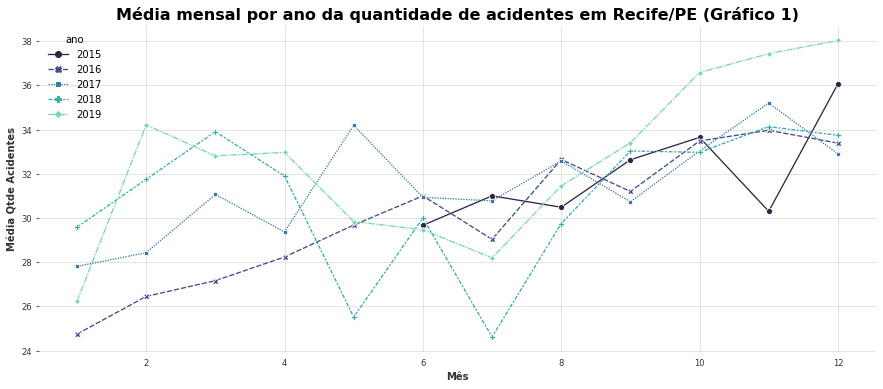

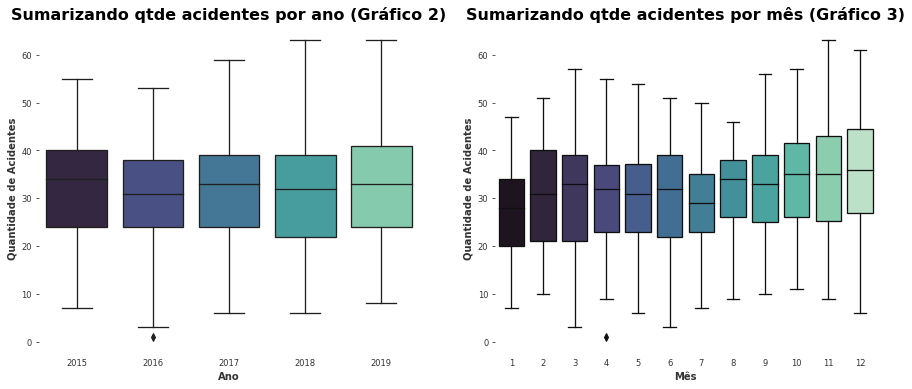

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
palette = sns.color_palette('mako', 5)

sns.lineplot(data=df, x='mes', y='num_acidentes', hue='ano', style='ano', markers=True, palette=palette, ci=None)
ax.set_title('Média mensal por ano da quantidade de acidentes em Recife/PE (Gráfico 1)', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Mês', fontsize = 10, fontdict=dict(weight='bold'))
ax.set_ylabel('Média Qtde Acidentes', fontsize = 10, fontdict=dict(weight='bold'))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(df['ano'], df['num_acidentes'], ax=ax[0], palette='mako')
ax[0].set_title('Sumarizando qtde acidentes por ano (Gráfico 2)', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Ano', fontsize = 10, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Quantidade de Acidentes', fontsize = 10, fontdict=dict(weight='bold'))
ax[0].grid(False)

sns.boxplot(df['mes'], df['num_acidentes'], ax=ax[1], palette='mako')
ax[1].set_title('Sumarizando qtde acidentes por mês (Gráfico 3)', fontsize = 16, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Mês', fontsize = 10, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Quantidade de Acidentes', fontsize = 10, fontdict=dict(weight='bold'))
ax[1].grid(False)

Estudando os dados de forma anual (**gráfico 2**) há um tímido aumento no crescimento (anual) mediano de acidentes, o que possivelmente indica **fraca tendência de crescimento** ao decorrer dos anos na quantidade de acidentes registrados.

Esse comportamento levanta a **hipótese** de uma **possível estacionariedade** da série.


Outro ponto importante é notar que aparentemente a série não apresenta uma sazonalidade mensal bem definida (**gráficos 1 e 3**).

O que sugere **investigar** se existe **sazonalidade** em períodos menores ou maiores que 1 mês.

# Estacionariedade

Observando graficamente a série ela apresenta características de uma série estacionária (evolui ao redor de uma média com variância relativamente constante).

Separando cada componente da série podemos perceber melhor se existe alguma tendência se formando ao longo da série.

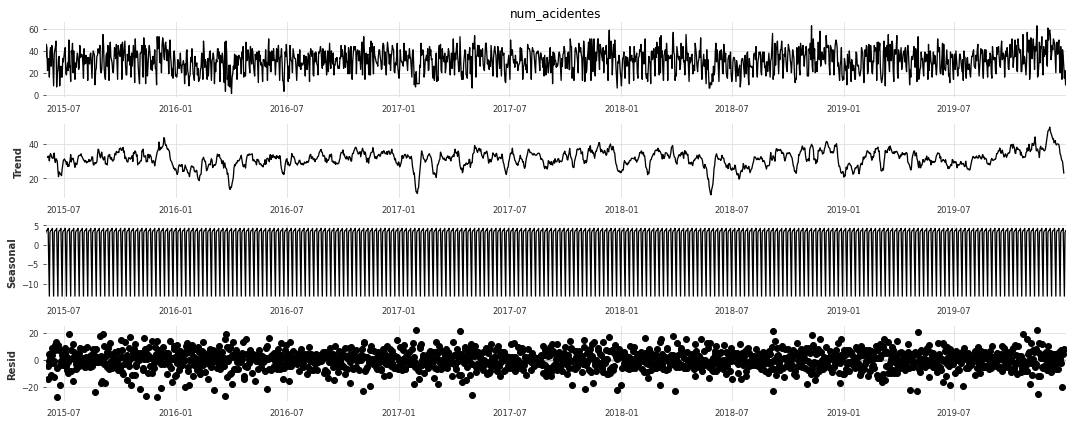

In [ ]:
decomp_viz = sm.tsa.seasonal_decompose(df['num_acidentes'], period=7)
fig = decomp_viz.plot()
fig.set_size_inches((15, 6))
fig.tight_layout()

Observando o gráfico que representa a componente de tendência (**Trend**), não existe indícios de tendência positiva ou negativa na série.

Um teste de **Dickey-Fuller aumentado** será feito para reforçarmos a hipótese acima sugestionada.

O teste verifica as seguintes hipóteses:

$H_0$: Série não é estacionária (possui raiz unitária)  
$H_1$: Série é estacionária (não possui raiz unitária)

A um nível de significância de 5%, temos que:

In [ ]:
ts = TimeSeries.from_series(df['num_acidentes'])

p_value_adf = stationarity_test_adf(ts)[1]
alpha = 0.05

print(f'p-valor = {p_value_adf}\n')

if p_value_adf < alpha:
    print('Rejeito H0. A série é estacionária!')
else:
    print('Não rejeito H0. Série não é estacionária!')

p-valor = 3.955178239358786e-09

Rejeito H0. A série é estacionária!


Os resultados obtidos com os testes e a análise gráfica endossam a hipótese que de a **série é estacionária**. 

Agora sabemos que se esse pressuposto será atendido caso seja necessário para a escolha de um modelo.

# Sazonalidade

Nas seções anteriores, não observou-se sinais de que a série tivesse características sazonais.

Vamos testar aqui alguns possíveis lags que podem indicar sazonalidade na série.

Os lags testados serão:
- Semanal
- Mensal
- Trimestral
- Semestral

In [ ]:
lags_to_test = [7, 30, 90, 180]

for i in lags_to_test:
    print(f'A série apresenta sazonalidade no lag {i}? {check_seasonality(ts, m=i, max_lag=180)[0]}')

A série apresenta sazonalidade no lag 7? True
A série apresenta sazonalidade no lag 30? False
A série apresenta sazonalidade no lag 90? False
A série apresenta sazonalidade no lag 180? False


Aparentemente o **lag 7** (semanal) se mostrou significativo. 

Vamos analisar o comportamento dos múltiplos lags usando a função de autocorrelação:

Text(0.5, 1.0, 'Função de AutoCorrelação')

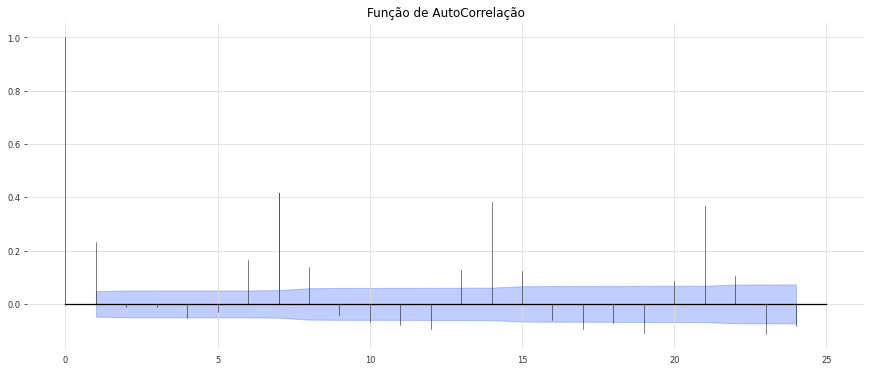

In [ ]:
plot_acf(ts, fig_size=(15, 6), m=7)
plt.title('Função de AutoCorrelação')

Observando o gráfico acima, podemos observar um padrão que se repete sempre em múltiplos do lag 7.

Podemos então concluir que existe uma sazonalidade semanal na série.

# **Relação entre número de acidentes e variáveis exógenas**

Inicialmente vamos verificar a distribuição das variáveis exógenas numéricas.

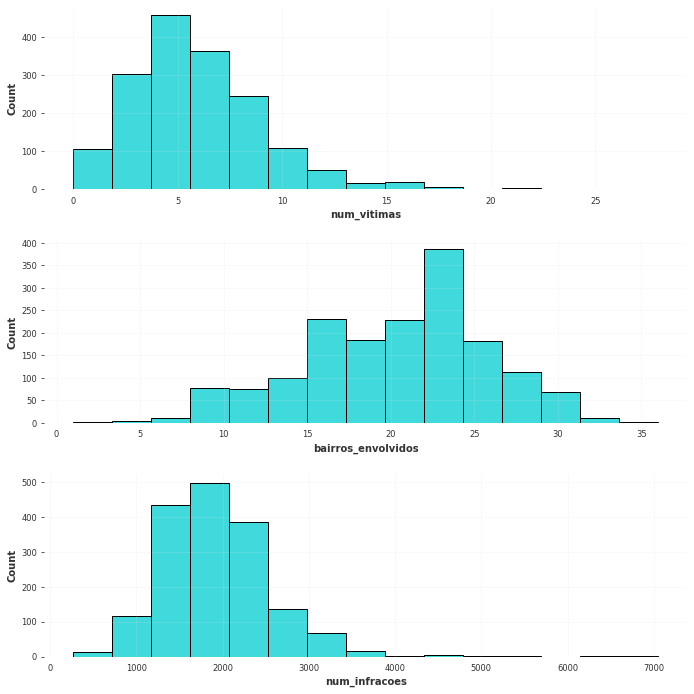

In [ ]:
num_plot = 1
vars = ['num_vitimas', 'bairros_envolvidos', 'num_infracoes']
plt.subplots(figsize=(10, 10))
for col in vars:
    plt.subplot(3, 1, num_plot)
    sns.histplot(data=df, x=col, bins=15, color = "darkturquoise")    
    plt.xlabel(col)
    plt.tight_layout(pad=2)
    plt.grid(alpha = 0.2)
    num_plot+=1
plt.show()

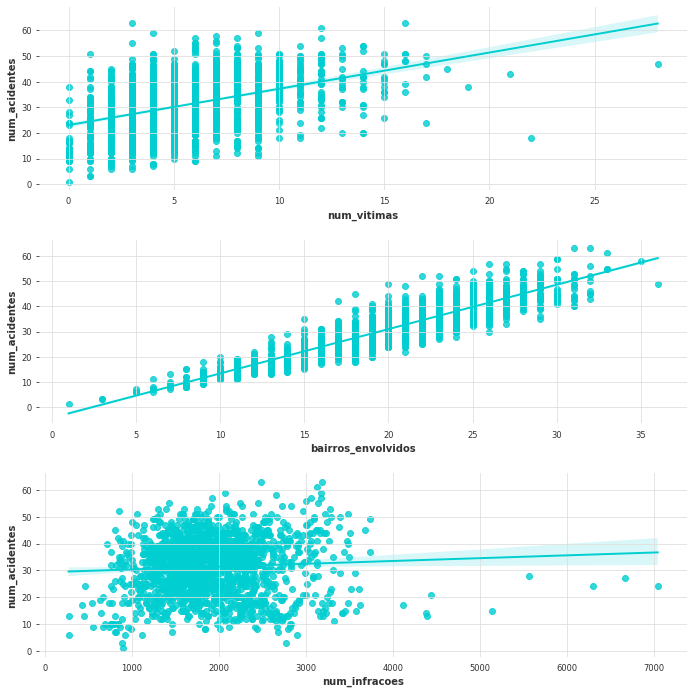

In [ ]:
num_plot = 1
plt.subplots(figsize=(10, 10))
for col in vars:
    plt.subplot(3, 1, num_plot)
    sns.regplot(x=col, y="num_acidentes", data=df, color = "darkturquoise")
    plt.xlabel(col)
    plt.tight_layout(pad=2)
    num_plot+=1
plt.show()

De acordo com os gráficos de dispersão, as variáveis `num_vitimas` e `bairros_envolvidos` apresentam relação linear com num_acidentes, enquanto que no gráfico de `num_infracoes` não parece haver padrão, contradizendo nossa suposição de que haveria relevância.

Vamos quantificar essas relações com base na métrica **Distance Correlation** que consegue capturar correlações não lineares também

In [ ]:
dist_corr_list = []
for i in vars:
    dist_corr = dcor.distance_correlation(df['num_acidentes'], df[i]) 
    print("Correlação entre num_acidentes e", i, "->", dist_corr)

Correlação entre num_acidentes e num_vitimas -> 0.40844520986620153
Correlação entre num_acidentes e bairros_envolvidos -> 0.8923794247562246
Correlação entre num_acidentes e num_infracoes -> 0.12544270617518868


Observamos que `num_infracoes` possui de fato correlação fraca com num_acidentes, portanto não utilizaremos no modelo como variável exógena.

# **Salvando dados**

In [ ]:
# df.drop('num_infracoes', axis = 1).to_csv(path + 'complete_dataset/acidentes_2015_2019.csv')